In [1]:
# !pip install -U scikit-learn -q

In [2]:
# !pip uninstall -v scikit-learn
!pip install -v scikit-learn -q
!pip install sktime -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.0/24.0 MB 41.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.9/132.9 kB 14.9 MB/s eta 0:00:00


In [3]:
#importing libraries
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
%matplotlib inline
import sklearn
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.linear_model import RidgeCV, LassoCV, Ridge, Lasso
from sklearn.metrics import mean_squared_error, r2_score
from sktime.performance_metrics.forecasting import mean_absolute_percentage_error, mean_absolute_error

In [4]:
train_df = pd.read_csv('/content/drive/MyDrive/mmm_data/train_data.csv')
test_df = pd.read_csv('/content/drive/MyDrive/mmm_data/test_data.csv')

train_df['date'] = pd.to_datetime(train_df['date'])
train_df['day_of_year'] = train_df['date'].dt.dayofyear

test_df['date'] = pd.to_datetime(test_df['date'])
test_df['day_of_year'] = test_df['date'].dt.dayofyear

print(train_df.shape, test_df.shape)

(1826, 19) (787, 19)


In [5]:
cols = train_df.columns.tolist()
to_remove = ['category', 'date', 'day_of_year']
cols = [col for col in cols if col not in to_remove]
train_df = train_df[cols]
test_df = test_df[cols]

#Recursive Feature Elimination

In [6]:
x_cols = cols.copy()
x_cols.remove('revenue')
y_col = "revenue"

In [7]:

#no of features
nof_list=np.arange(1,len(cols)+1)
high_score=0
#Variable to store the optimum features
nof=0
score_list =[]
for n in np.arange(1,len(cols)+1):

  x_trian = train_df[x_cols]
  y_train = train_df[y_col]
  x_test = test_df[x_cols]
  y_test = test_df[y_col]

  model = LinearRegression()
  rfe = RFE(model,n_features_to_select=n,step=1)
  x_train_rfe = rfe.fit_transform(x_trian,y_train)
  x_test_rfe = rfe.transform(x_test)

  print(x_train_rfe)
  model.fit(x_train_rfe,y_train)
  score = model.score(x_test_rfe,y_test)
  score_list.append(score)
  print(f"{score}>{high_score}")
  if(score>high_score):
    high_score = score
    nof = nof_list[n]

print("Optimum number of features: %d" %nof)
print("Score with %d features: %f" % (nof, high_score))

[[106.7]
 [106.7]
 [106.7]
 ...
 [102.1]
 [102.1]
 [102.1]]
-0.6583708560159698>0
[[104.9 106.7]
 [104.9 106.7]
 [104.9 106.7]
 ...
 [101.5 102.1]
 [101.5 102.1]
 [101.5 102.1]]
-0.8892630952755618>0
[[104.9  96.3 106.7]
 [104.9  96.3 106.7]
 [104.9  96.3 106.7]
 ...
 [101.5 103.6 102.1]
 [101.5 103.6 102.1]
 [101.5 103.6 102.1]]
-0.2926439638953886>0
[[104.9       96.3      106.7       14.104193]
 [104.9       96.3      106.7       13.298758]
 [104.9       96.3      106.7       13.200691]
 ...
 [101.5      103.6      102.1       11.065644]
 [101.5      103.6      102.1       10.512018]
 [101.5      103.6      102.1       10.814541]]
-0.2936764839726089>0
[[104.9       96.3      106.7      361.62      14.104193]
 [104.9       96.3      106.7      361.62      13.298758]
 [104.9       96.3      106.7      361.62      13.200691]
 ...
 [101.5      103.6      102.1      361.62      11.065644]
 [101.5      103.6      102.1      361.62      10.512018]
 [101.5      103.6      102.1      361.62

In [8]:
X = train_df[x_cols]
y = train_df[y_col]
cols = list(X.columns)
model = LinearRegression()#Initializing RFE model
rfe = RFE(model, n_features_to_select=22,step=1)             #Transforming data using RFE
X_rfe = rfe.fit_transform(X,y)  #Fitting the data to model
model.fit(X_rfe,y)
temp = pd.Series(rfe.support_,index = cols)
selected_features_rfe = temp[temp==True].index
print(selected_features_rfe)

Index(['demand', 'consumer_price_index', 'consumer_confidence_index',
       'producer_price_index', 'unit_price', 'ad_expense_sms',
       'ad_expense_newspaper', 'ad_expense_radio', 'ad_expense_tv',
       'ad_expense_internet', 'gross_rating_point_newspaper',
       'gross_rating_point_sms', 'gross_rating_point_radio',
       'gross_rating_point_internet', 'gross_rating_point_tv'],
      dtype='object')


# Fit the model with selected features

In [9]:
model_new = LinearRegression()
model_new.fit(train_df[selected_features_rfe],train_df[y_col])

LinearRegression()

# Model performance for the first 3 months, 6 months, 1 year, 1.5 years, and for the full inference period

Residuals vs Predictions: Use this plot to assess whether the model's predictions are consistent across the range of observed values.

Residuals vs Actuals: Use this plot to understand the distribution of errors in relation to the actual data points. Look for any systematic patterns or outliers.

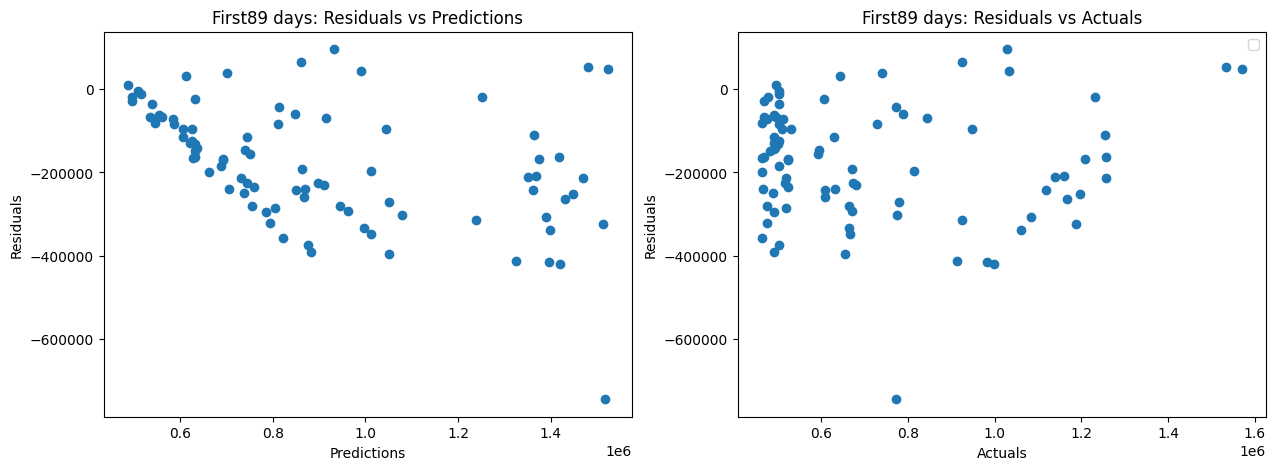

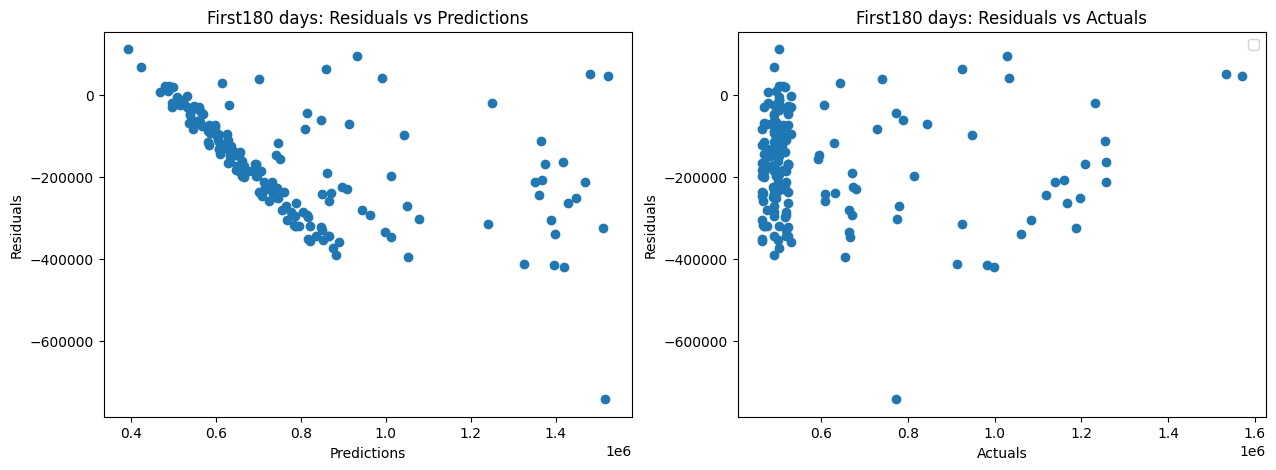

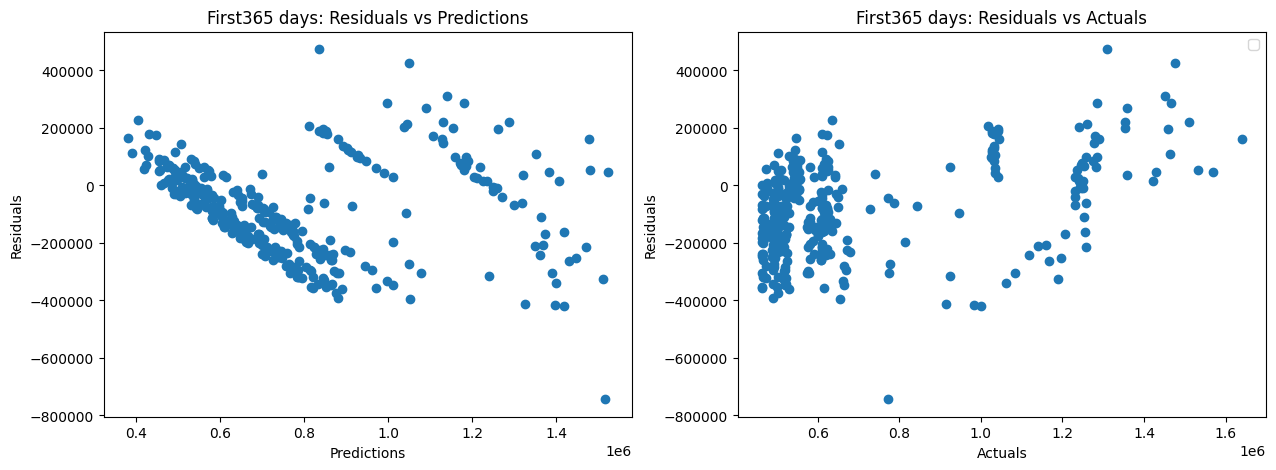

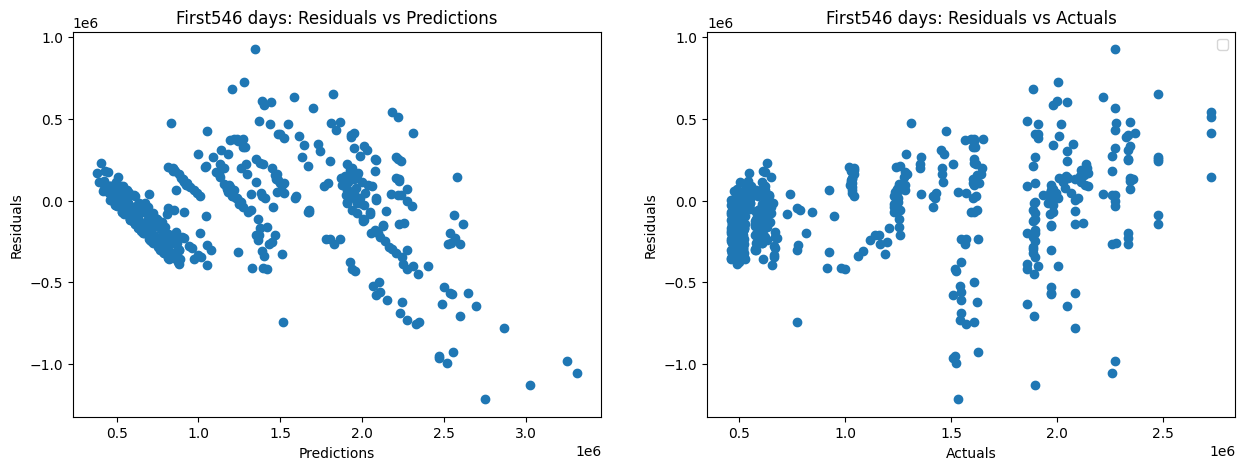

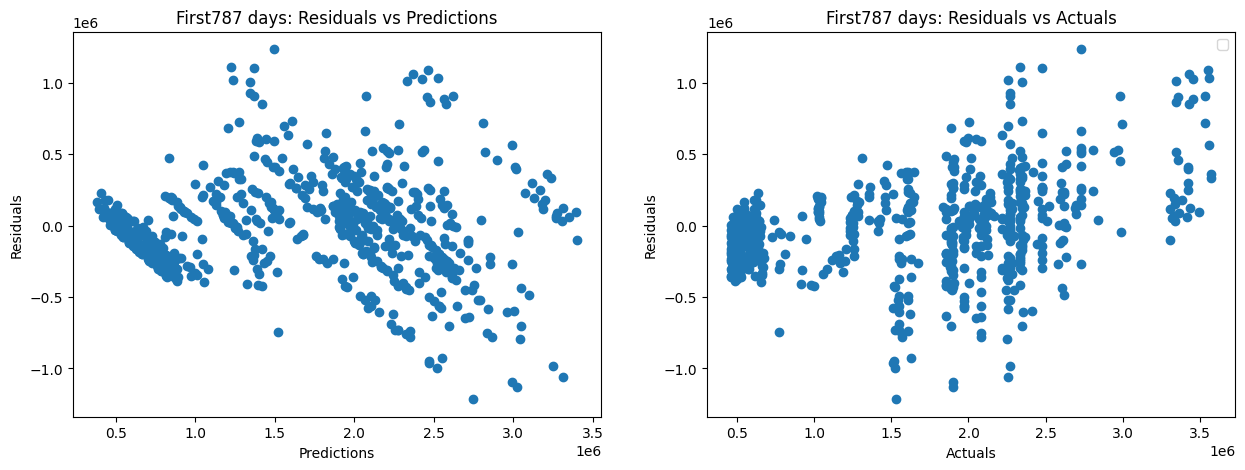

In [10]:
results_list = []
for inf_days in [89,180,365,546,787]:
  y_pred = model_new.predict(test_df[selected_features_rfe][:inf_days])

  # Compare the models' performance
  linear_rmse = np.sqrt(mean_squared_error(test_df[y_col][:inf_days], y_pred))
  linear_r2 = r2_score(test_df[y_col][:inf_days], y_pred)
  linear_smape = mean_absolute_percentage_error(test_df[y_col][:inf_days], y_pred, symmetric=True)
  linear_mae = mean_absolute_error(test_df[y_col][:inf_days], y_pred, symmetric=True)

  results_list.append({
      'inference_days': inf_days,
      'rmse': linear_rmse,
      'r2': linear_r2,
      'smape': linear_smape,
      'mae': linear_mae
  })

  residuals = test_df[y_col][:inf_days]-y_pred

  fig, ax = plt.subplots(nrows=1, ncols=2,figsize=(15, 5))
  ax[0].scatter(y_pred, residuals)
  ax[1].scatter(test_df[y_col][:inf_days],residuals)

  ax[0].set_xlabel('Predictions')
  ax[0].set_ylabel('Residuals')
  ax[1].set_xlabel('Actuals')
  ax[1].set_ylabel('Residuals')

  ax[0].set_title(f'First{inf_days} days: Residuals vs Predictions')
  ax[1].set_title(f'First{inf_days} days: Residuals vs Actuals')

  plt.legend()
  plt.show()

Text(0, 0.5, 'Revenue')

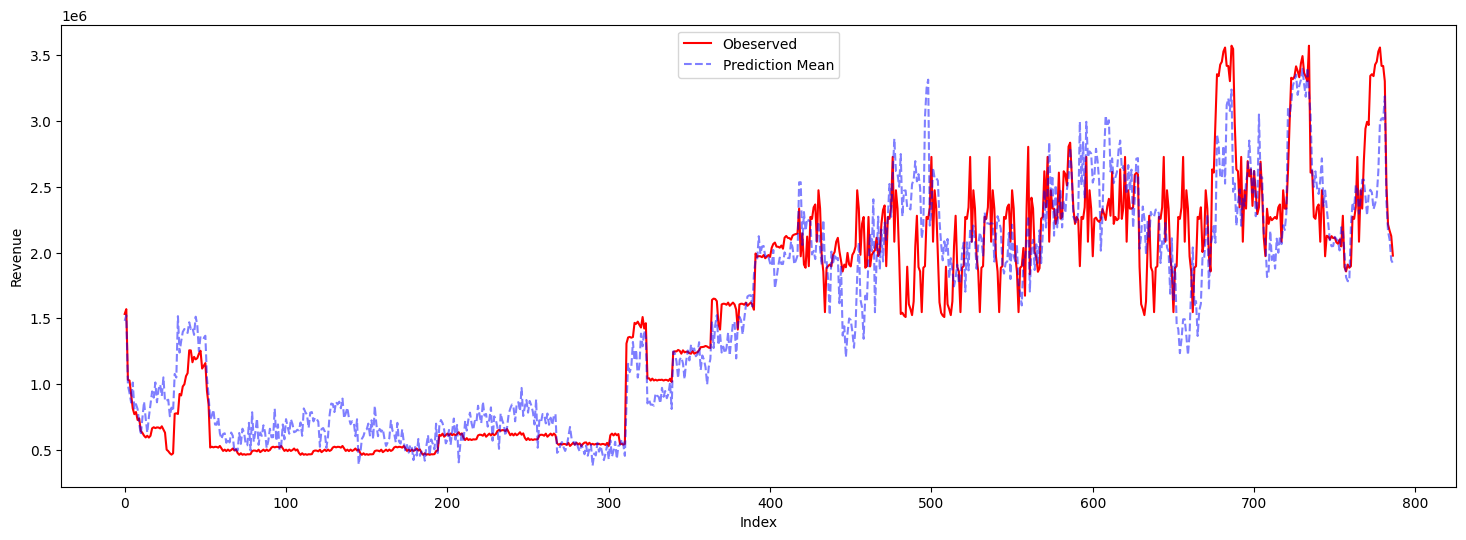

In [11]:
fig, ax = plt.subplots(figsize = (18, 6))

ax.plot(test_df[y_col], color = "red", label="Obeserved")
ax.plot(y_pred, color = "blue", linestyle='dashed', alpha = 0.5, label="Prediction Mean")
plt.legend(loc='upper center')
plt.xlabel("Index")
plt.ylabel("Revenue")

In [12]:
results_df = pd.DataFrame(results_list)
results_df

,inference_days,rmse,r2,smape,mae
0,89,224281.753514,0.356829,0.234171,184491.906508
1,180,211418.790299,0.119132,0.258361,177408.628735
2,365,178677.412709,0.608678,0.201969,143372.073866
3,546,272108.359541,0.833277,0.186630,197098.727673
4,787,322747.210451,0.860342,0.170946,233225.388259
